In [9]:
import uns
from uns import training
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn import cluster
def colormap(N): 
    return colors.ListedColormap(plt.cm.plasma(np.linspace(0,1,N)))


# Prepare the numeric array

In [2]:
Columns = ['centrow', #'centcol',
          #'contH', 'contW', 'contymax', 'contymin', 
           'maskarea',
           #'skelavgdist', 
           'skeldist10', 
           #'skeldist25',
           #'skeldist50', 
           #'skeldist75', 
           #'skeldist90', 
           #'skelmaxdist', 
           #'skelpixels',
           #'moment_hu_I0', 'moment_hu_I1',
           #'moment_hu_I2', 'moment_hu_I3', 'moment_hu_I4', 'moment_hu_I5', 'moment_hu_I6',
           'svdx0', 'svdx1', 'svdy0', 'svdy1',
           #'sv0', 'sv1', 'sv2', 'sv3'
            ]

data = training[training['hasmask']][Columns]
data.head(10)

,centrow,maskarea,skeldist10,svdx0,svdx1,svdy0,svdy1
0,0.215119,0.137656,0.003448,-0.288255,0.144863,0.233198,0.179064
1,0.253135,0.160957,0.003855,-0.406344,0.085061,0.132856,0.260161
2,0.212435,0.181390,0.004877,-0.368935,0.193910,0.286360,0.249826
3,0.190581,0.125667,0.003448,-0.297458,-0.018831,-0.023345,0.239933
6,0.209559,0.155641,0.003855,-0.374071,0.084245,0.118007,0.267049
13,0.218306,0.171849,0.004877,-0.281118,0.236596,0.295410,0.225149
14,0.193618,0.127306,0.003448,-0.292360,-0.020699,-0.024171,0.250367
16,0.220568,0.140475,0.003855,-0.314163,0.084060,0.102150,0.258527
19,0.211625,0.157450,0.003855,-0.374265,0.063109,0.082174,0.287432
22,0.220191,0.173158,0.004877,-0.294351,0.231656,0.260556,0.261702


In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
#X = data.values
X = StandardScaler().fit_transform(data.values)
P = pca.fit(X)
pca.explained_variance_ratio_
pft = P.fit_transform(X)

In [4]:
pft.shape

(2323, 7)

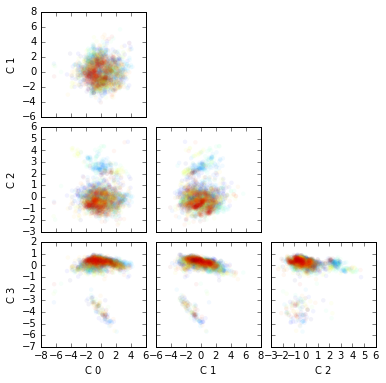

In [5]:
# color based on predicted mask area
pred_size = 210*290
pred_area = training.ix[training['hasmask'],'model_400_hist_050']/pred_size
mask_area = training.ix[training['hasmask'],'maskarea']**2
c = training.ix[training['hasmask'],'subject'].values
uns.plot_pca_comps(pft, 4, alpha=0.05, edgecolors='none', color=c, cmap=plt.cm.jet)

## Clustering

In [6]:
def plot_group_masks(groupby, ax=None, n=50, split=False):
    clusters = training[training['hasmask']].groupby(by=groupby)
    ncol = len(clusters)
    col = colormap(ncol)
    
    if ax is None:
        if not split:
            fig, ax = plt.subplots()
    for i, (key, group) in enumerate(clusters):
        color = col.colors[i,:]
        if split:
            fig, ax = plt.subplots()
        sub = group.sample(n=min(n,len(group)))[['centcol','contour','unitcontour','centrow']]
        D = np.dstack(sub['contour'].values)
        C = np.dstack(sub['centcol'].values)
        ax.plot(D[1,:,:]-C[0,:,:]*580,D[0,:,:], color=color, alpha=0.5, lw=1.5)
        
    ax.axis('square')
    return col
#col = plot_group_masks(groupby='KMeansCluster', n=20)

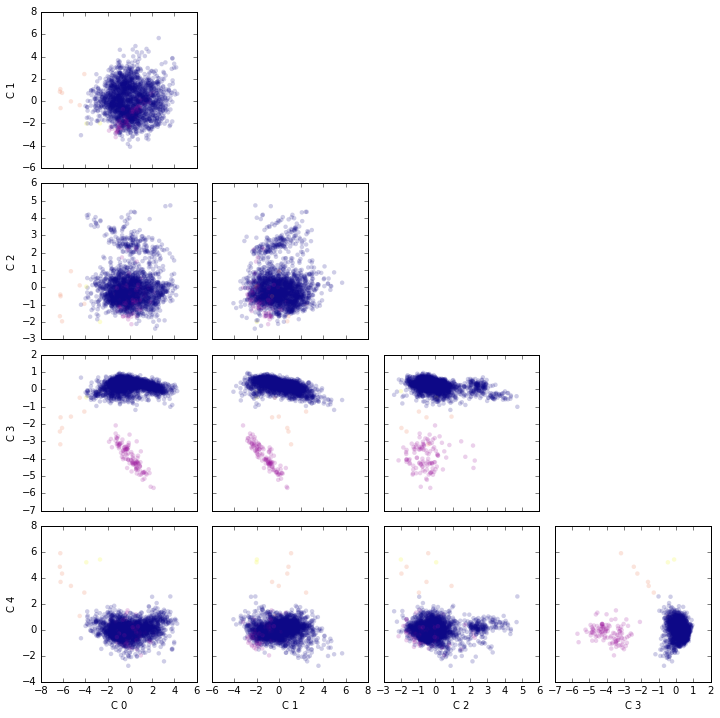

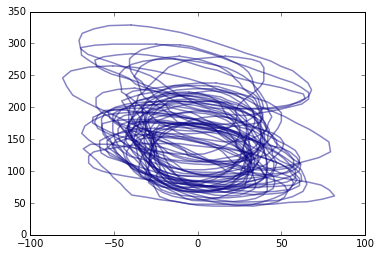

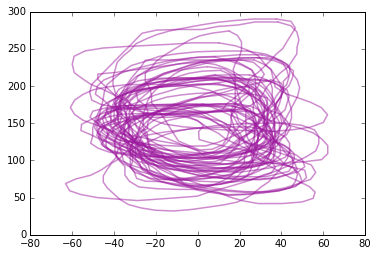

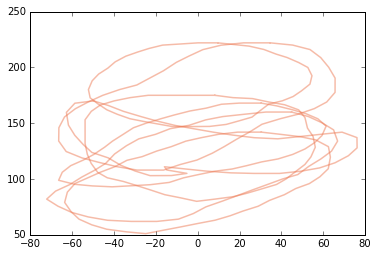

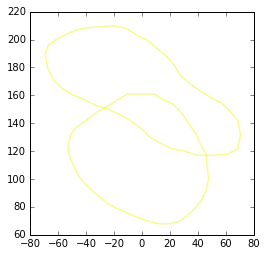

In [10]:
bandwidth = cluster.estimate_bandwidth(X, quantile=.3, n_samples=50)
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(P.transform(X))
labels = ms.labels_+1
training.loc[training['hasmask'],'MeanShift'] = labels

uns.plot_pca_comps(pft, 5, figsize=(12,12),
               alpha=0.2, 
               edgecolors='none', 
               color=ms.labels_, 
               cmap=colormap(len(set(labels)))
              )

plot_group_masks(groupby='MeanShift',split=True)

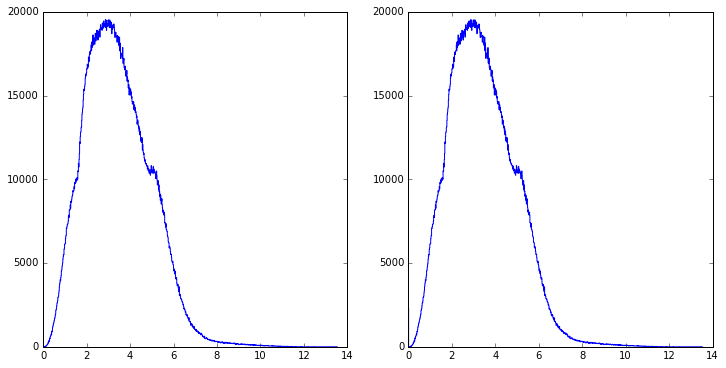

In [11]:
from sklearn import metrics
DX = metrics.pairwise_distances(X)
DPX = metrics.pairwise_distances(P.transform(X))
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist(DX.flatten(), bins=1000, histtype='step')
ax[1].hist(DPX.flatten(),bins=1000, histtype='step')
plt.show()

Found 3 clusters


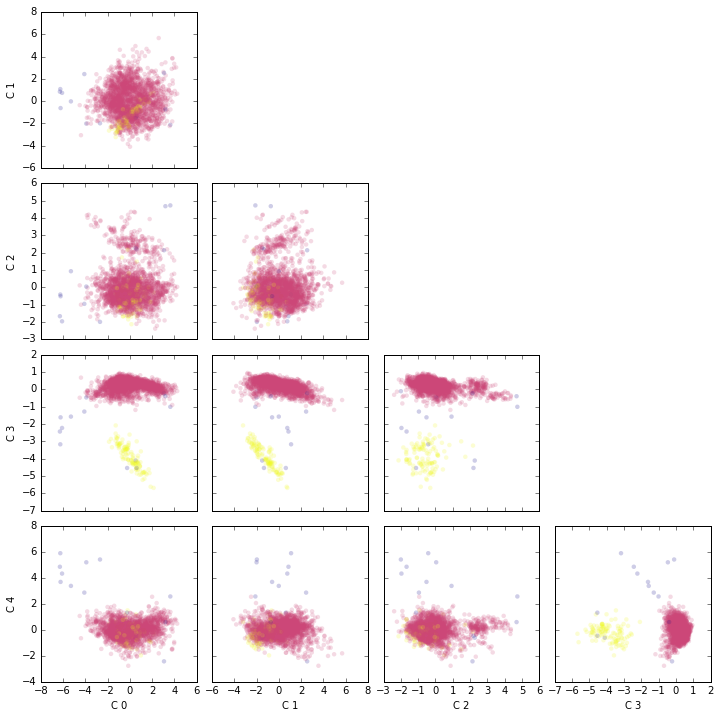

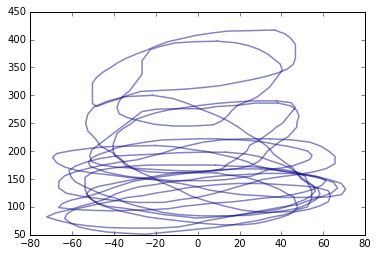

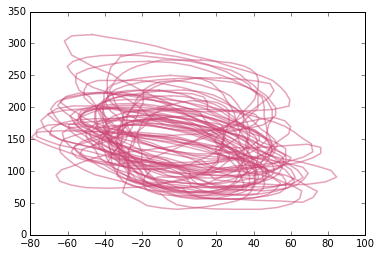

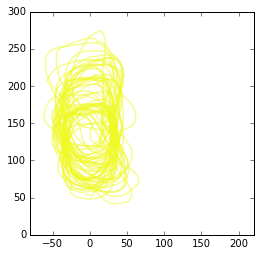

In [12]:
db = cluster.DBSCAN(eps=2, min_samples=15)
db.fit(pft)
labels = db.labels_
training.loc[training['hasmask'],'DBSCAN'] = labels

print('Found {:d} clusters'.format(len(set(labels))))
uns.plot_pca_comps(pft, 5, figsize=(12,12),
               alpha=0.2, 
               edgecolors='none', 
               color=labels,
               cmap=colormap(len(set(labels))))

plot_group_masks(groupby='DBSCAN', split=True)

In [19]:
ac = cluster.AgglomerativeClustering(n_clusters=3)
ac.fit(pft)
labels = ac.labels_
training.loc[training['hasmask'],'AgglomerativeClustering'] = labels

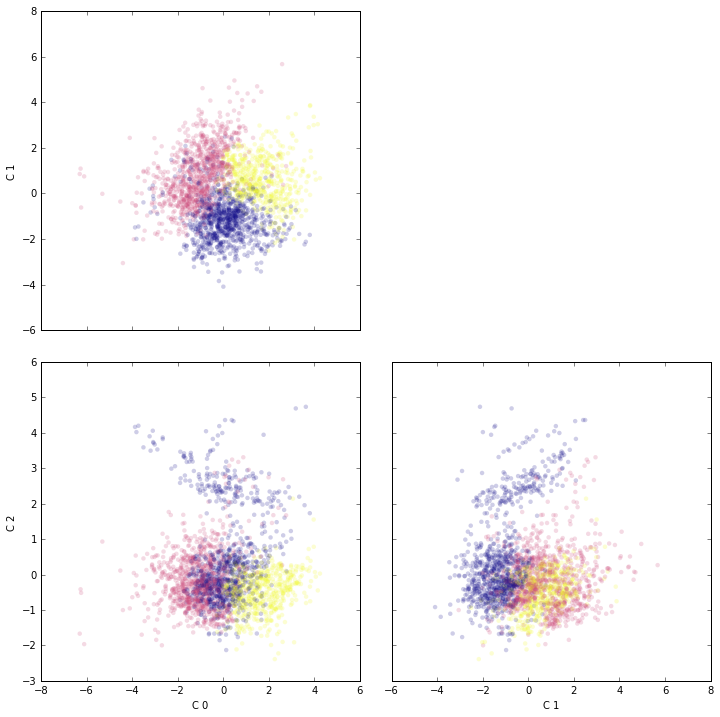

In [20]:
uns.plot_pca_comps(pft, 3, figsize=(12,12),
               alpha=0.2, 
               edgecolors='none', 
               color=labels,
               cmap=colormap(len(set(labels))))

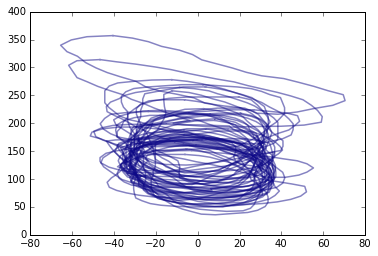

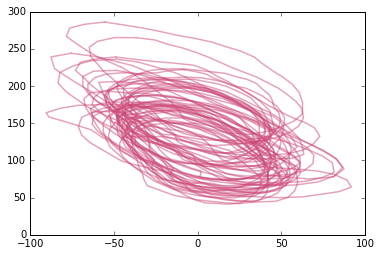

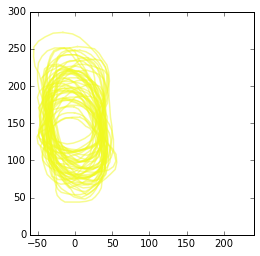

In [21]:
plot_group_masks(groupby='AgglomerativeClustering', split=True)

In [22]:
model_idx = np.logical_and(training['hasmask'],training['model_901']=='validate')
groups = training.ix[model_idx, ['AgglomerativeClustering','maskarea', 'model_902_hist_050', 'model_702_hist_050', 'model_802_hist_050']].groupby(by='AgglomerativeClustering')
groups.mean()

,maskarea,model_902_hist_050,model_702_hist_050,model_802_hist_050
AgglomerativeClustering,,,,
0.0,0.158871,30.624060,35.045113,159.421053
1.0,0.173896,36.537383,40.084112,191.149533
2.0,0.179688,34.371134,35.793814,189.587629


In [23]:
groups = training.ix[model_idx, ['DBSCAN','maskarea', 'model_902_hist_050', 'model_702_hist_050', 'model_802_hist_050']].groupby(by='DBSCAN')
groups.mean()

,maskarea,model_902_hist_050,model_702_hist_050,model_802_hist_050
DBSCAN,,,,
-1.0,0.171478,0.000000,0.000000,276.000000
0.0,0.170469,34.290476,37.714286,181.716667
1.0,0.174121,35.826087,37.869565,169.652174


In [133]:
groups = training.ix[model_idx, ['MeanShift','maskarea', 'model_400_hist_050','model_902_hist_050', 'model_702_hist_050', 'model_802_hist_050']].groupby(by='MeanShift')
groups.mean()

,maskarea,model_400_hist_050,model_902_hist_050,model_702_hist_050,model_802_hist_050
MeanShift,,,,,
1.0,0.170469,133.659524,34.290476,37.714286,181.716667
2.0,0.174121,110.521739,35.826087,37.869565,169.652174
4.0,0.171478,91.000000,0.000000,0.000000,276.000000


In [99]:
spectral = cluster.SpectralClustering(n_clusters=2,
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors")
spectral.fit(pft)

SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver='arpack', eigen_tol=0.0,
          gamma=1.0, kernel_params=None, n_clusters=2, n_init=10,
          n_neighbors=10, random_state=None)

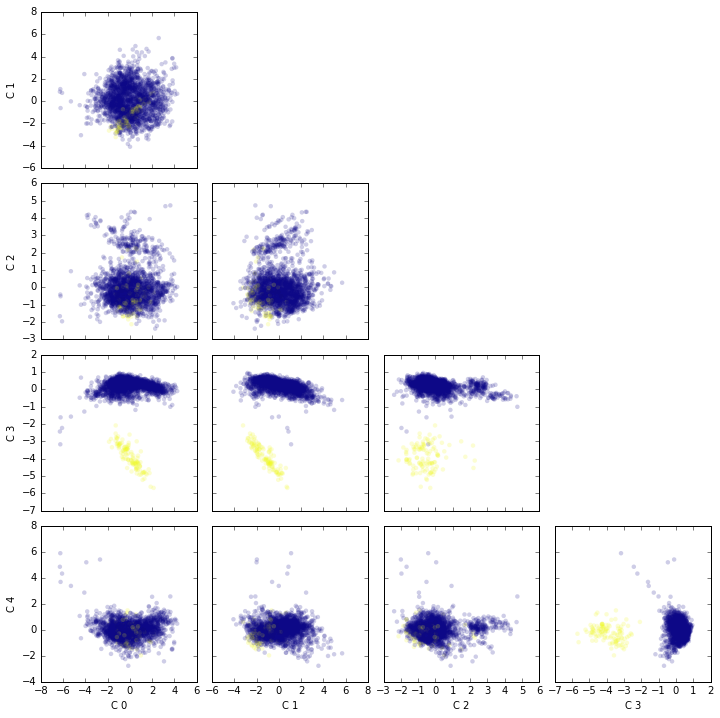

In [103]:
labels = spectral.labels_
training.loc[training['hasmask'],'Spectral'] = labels
uns.plot_pca_comps(pft, 5, figsize=(12,12),
               alpha=0.2, 
               edgecolors='none', 
               color=labels,
               cmap=colormap(len(set(labels))))

In [134]:
groups = training.ix[model_idx, ['Spectral','maskarea', 'model_902_hist_050', 'model_702_hist_050', 'model_802_hist_050']].groupby(by='Spectral')
groups.mean()

,maskarea,model_902_hist_050,model_702_hist_050,model_802_hist_050
Spectral,,,,
0.0,0.170471,34.209026,37.624703,181.940618
1.0,0.174121,35.826087,37.869565,169.652174


In [135]:
groups = training.ix[model_idx, ['subject','maskarea', 'model_902_hist_050', 'model_702_hist_050', 'model_802_hist_050']].groupby(by='subject')
groups.mean()

,maskarea,model_902_hist_050,model_702_hist_050,model_802_hist_050
subject,,,,
9,0.167612,26.223881,29.507463,162.895522
15,0.170784,20.403226,27.983871,210.322581
17,0.170827,14.173913,33.521739,210.347826
18,0.174125,14.928571,31.750000,153.964286
29,0.183898,41.262295,35.393443,211.639344
37,0.170803,44.850467,47.766355,191.971963
44,0.164174,51.051282,48.179487,153.166667
46,0.158378,9.000000,17.277778,111.000000


In [25]:
training.to_msgpack('training.bin')